# Projeto - Classificação de Pinturas com CNN

## Imports das bibliotecas necessárias

In [4]:
# instalação da lib do Kaggle (kagglehub) para realizar download
# !pip install kagglehub

In [ ]:
# imports de bibliotecas usadas
import os
import shutil
from PIL import Image
from collections import Counter

import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import v2, ToTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

## Importação do [dataset do Kaggle](https://www.kaggle.com/datasets/steubk/wikiart)

In [2]:
# download a partir do kaggle (usando biblioteca kagglehub)

path = kagglehub.dataset_download("steubk/wikiart")
print("Path to dataset files:", path) # Path to dataset files: /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1

100%|██████████| 31.4G/31.4G [13:36<00:00, 41.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1


In [3]:
list_directory = os.listdir(path)
print()
print(len(list_directory), list_directory)


29 ['Expressionism', 'Cubism', 'wclasses.csv', 'Action_painting', 'Fauvism', 'Mannerism_Late_Renaissance', 'Analytical_Cubism', 'New_Realism', 'Early_Renaissance', 'Northern_Renaissance', 'Post_Impressionism', 'Rococo', 'Contemporary_Realism', 'Pointillism', 'Pop_Art', 'Minimalism', 'Naive_Art_Primitivism', 'Color_Field_Painting', 'High_Renaissance', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e', 'Abstract_Expressionism', 'Art_Nouveau_Modern', 'Romanticism', 'Synthetic_Cubism']


In [6]:
# classes.csv
# path = '/root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/'
dataset_path = os.path.join(path, 'classes.csv')
df = pd.read_csv(dataset_path)

## Alterações nos dados

### Para obtenção de melhores resultados, em comparação com os obtidos usando Keras, algumas medidas vão ser tomadas:

- Retirada de imagens que apresentam mais de uma classificação

In [7]:
# retirada de imagens com mais de uma classificação
# exclusão desses dados é feita no sistema (antes de carregamento dos dados para um dataset)

# lista para salvar índices das instâncias a serem excluídas do df (pois os dados correspondentes foram excluídos)
instance_remove = []

for index, instance in df.iterrows():
  file_path = str(instance['filename'])
  image_classes = str(instance['genre'])

  # busca uma vírgula na string das classes da pintura
  if (image_classes.find(',') != -1):
    # encontrou vírgula
    file_path = os.path.join(path, file_path)
    try:
      os.remove(file_path)
      print('Removed: ', file_path)
    except Exception as e:
      print('Error: failed', file_path)
    # adiciona à lista o índice da linha para ser excluída do df
    instance_remove.append(index)

# retira as linhas com base nos índices
df = df.drop(instance_remove)
# reorganiza índices; drop=True faz com que uma coluna Index NÃO seja inserida
df = df.reset_index(drop=True)

Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/brice-marden_untitled-press-series-1972-1.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_al-lazar-man-in-a-hotel-room-1954.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_harold-rosenberg-1956.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_john-f-kennedy-1962.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_john-f-kennedy-1963-1.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_john-f-kennedy-1963.jpg
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Abstract_Expressionism/elaine-de-kooning_portrait-of-jack-greenbaum-1959.jpg
Removed:  /root/.cache/kagglehub/da

- Retirada de classes com poucas instâncias

In [8]:
len(df), df['genre'].value_counts()

(78642,
 genre
 ['Impressionism']                 12847
 ['Realism']                       10534
 ['Romanticism']                    6896
 ['Expressionism']                  6280
 ['Post Impressionism']             6274
 ['Baroque']                        4202
 ['Symbolism']                      4174
 ['Art Nouveau Modern']             4155
 ['Abstract Expressionism']         2574
 ['Northern Renaissance']           2550
 ['Naive Art Primitivism']          2299
 ['Rococo']                         2070
 ['Cubism']                         2002
 ['Color Field Painting']           1486
 ['Pop Art']                        1447
 ['Early Renaissance']              1387
 ['High Renaissance']               1339
 ['Mannerism Late Renaissance']     1275
 ['Minimalism']                     1250
 ['Ukiyo e']                        1159
 ['Fauvism']                         747
 ['Pointillism']                     490
 ['Contemporary Realism']            481
 ['New Realism']                     312
 

In [ ]:
# vamos retirar algumas das classes que apresentam poucas instâncias de dados
# Fauvism, Pointillism, Contemporary Realism, New Realism, Synthetic Cubism, Analytical Cubism, Action painting
#  ['Fauvism']                         747
#  ['Pointillism']                     490
#  ['Contemporary Realism']            481
#  ['New Realism']                     312
#  ['Synthetic Cubism']                216
#  ['Analytical Cubism']               110
#  ['Action painting']                  86

# a retirada das classes é feita antes da captura do dataset a partir do diretório

list_directory = os.listdir(path)
print(len(list_directory), list_directory)

direc_remove = ['Fauvism', 'Pointillism', 'Contemporary_Realism', 'New_Realism', 'Synthetic_Cubism', 'Analytical_Cubism', 'Action_painting']

for folder in direc_remove:
  folder_path = os.path.join(path, folder)
  try:
    if os.path.isdir(folder_path):
      shutil.rmtree(folder_path)
      print('Removed: ', path + folder, end='. ')
  except Exception as e:
    print('Error: failed', path + folder, end='. ')

list_directory = os.listdir(path)
print()
print(len(list_directory), list_directory)

29 ['Expressionism', 'Cubism', 'wclasses.csv', 'Action_painting', 'Fauvism', 'Mannerism_Late_Renaissance', 'Analytical_Cubism', 'New_Realism', 'Early_Renaissance', 'Northern_Renaissance', 'Post_Impressionism', 'Rococo', 'Contemporary_Realism', 'Pointillism', 'Pop_Art', 'Minimalism', 'Naive_Art_Primitivism', 'Color_Field_Painting', 'High_Renaissance', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e', 'Abstract_Expressionism', 'Art_Nouveau_Modern', 'Romanticism', 'Synthetic_Cubism']
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Fauvism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Pointillism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Contemporary_Realism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1New_Realism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Synthetic_Cubism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Analytica

- Escolha de classes que apresentem imagens com padrão visível
  - no dataset, classes como 'Pop Art', 'Fauvism', apresentam dados muito variados e de difícil verificação do padrão presente. Para essas classes, o modelo teve baixa precisão em classificá-las. Assim, a medida de decisão de quais classes serão retiradas com base nesse aspecto vai ser realizada.
  - classes que serão retiradas com base nessa análise:

In [10]:
list_directory = os.listdir(path)
print(len(list_directory), list_directory)

direc_remove = ['Expressionism', 'Pop_Art', 'Naive_Art_Primitivism', 'Abstract_Expressionism']

for folder in direc_remove:
  folder_path = os.path.join(path, folder)
  try:
    if os.path.isdir(folder_path):
      shutil.rmtree(folder_path)
      print('Removed: ', path + folder, end='. ')
  except Exception as e:
    print('Error: failed', path + folder, end='. ')

list_directory = os.listdir(path)
print()
print(len(list_directory), list_directory)

22 ['Expressionism', 'Cubism', 'wclasses.csv', 'Mannerism_Late_Renaissance', 'Early_Renaissance', 'Northern_Renaissance', 'Post_Impressionism', 'Rococo', 'Pop_Art', 'Minimalism', 'Naive_Art_Primitivism', 'Color_Field_Painting', 'High_Renaissance', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e', 'Abstract_Expressionism', 'Art_Nouveau_Modern', 'Romanticism']
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Expressionism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Pop_Art. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Naive_Art_Primitivism. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Abstract_Expressionism. 
18 ['Cubism', 'wclasses.csv', 'Mannerism_Late_Renaissance', 'Early_Renaissance', 'Northern_Renaissance', 'Post_Impressionism', 'Rococo', 'Minimalism', 'Color_Field_Painting', 'High_Renaissance', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e'

- União de classes semelhante
  - Há 4 classes relativas à Renascença; os diretórios serão unidos em somente um

In [11]:
renaissances_dirs = ['Mannerism_Late_Renaissance', 'Early_Renaissance', 'High_Renaissance', 'Northern_Renaissance']
one_renaissance_dir = path + '/Renaissance'

os.makedirs(one_renaissance_dir, exist_ok=True)

for dir in renaissances_dirs:
  # une o caminho em path aos diretórios
  source_path = os.path.join(path, dir)
  # verifica se caminho existe
  if os.path.exists(source_path):
    for file_name in os.listdir(source_path):
      file_name = os.path.join(source_path, file_name)
      if os.path.isfile(file_name):
        try:
          shutil.copy(file_name, one_renaissance_dir)
          print('Cópia do arquivo realizada: ', file_name)
        except Exception as e:
          print('Erro ao copiar arquivo: ', file_name)
          print('Erro:', e)
  else:
    print(f'Diretório não encontrado: {source_path}')

Streaming output truncated to the last 5000 lines.
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/filippo-brunelleschi_saint-peter-1413.jpg
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/fra-angelico_perugia-altarpiece-central-panel-1448.jpg
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/benozzo-gozzoli_san-domenico-annunciation.jpg
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/benozzo-gozzoli_st-augustine-departing-for-milan-detail-1465.jpg
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/andrea-del-castagno_holy-trinity-with-st-jerome.jpg
Cópia do arquivo realizada:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1/Early_Renaissance/carlo-crivelli_saint-james-the-elder-saint-bernard-of-siena

In [12]:
list_directory = os.listdir(one_renaissance_dir)
print()
print(len(list_directory), list_directory)


6558 ['joachim-wtewael_adoration-by-the-shepherds-1625.jpg', 'lucas-cranach-the-elder_john-duke-of-saxony.jpg', 'luca-signorelli_adoration-of-the-shepherds.jpg', 'sandro-botticelli_the-story-of-virginia-1504(1).jpg', 'fra-angelico_deposition-from-the-cross-1440.jpg', 'piero-della-francesca_the-madonna-del-parto-1460(1).jpg', 'hans-baldung_portrait-of-a-lady-1530.jpg', 'hans-holbein-the-younger_triumph-of-wealth.jpg', 'domenico-ghirlandaio_st-barbara.jpg', 'piero-della-francesca_federigo-da-montefeltro-1465(1).jpg', 'hieronymus-bosch_the-temptation-of-st-anthony-1516-4.jpg', 'mabuse_adam-and-eve-in-paradise.jpg', 'albrecht-durer_portrait-of-emperor-maximilian-i-1519.jpg', 'hans-baldung_hercules-and-antaeus-1531.jpg', 'carlo-crivelli_apostles-1473.jpg', 'benozzo-gozzoli_procession-of-the-magus-caspar-detail-1461-5.jpg', 'jean-fouquet_banquet-given-by-charles-v-1338-80-in-hhonour-of-his-uncle-emperor-charles-iv-1316-78-in-1378-1460.jpg', 'maerten-van-heemskerck_st-peter-s-basilica-seen-f

In [13]:
list_directory = os.listdir(path)
print(len(list_directory), list_directory)

renaissances_dirs = ['Mannerism_Late_Renaissance', 'Early_Renaissance', 'High_Renaissance', 'Northern_Renaissance']

for folder in renaissances_dirs:
  folder_path = os.path.join(path, folder)
  try:
    if os.path.isdir(folder_path):
      shutil.rmtree(folder_path)
      print('Removed: ', path + folder, end='. ')
  except Exception as e:
    print('Error: failed', path + folder, end='. ')

list_directory = os.listdir(path)
print()
print(len(list_directory), list_directory)

19 ['Cubism', 'wclasses.csv', 'Renaissance', 'Mannerism_Late_Renaissance', 'Early_Renaissance', 'Northern_Renaissance', 'Post_Impressionism', 'Rococo', 'Minimalism', 'Color_Field_Painting', 'High_Renaissance', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e', 'Art_Nouveau_Modern', 'Romanticism']
Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Mannerism_Late_Renaissance. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Early_Renaissance. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1High_Renaissance. Removed:  /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1Northern_Renaissance. 
15 ['Cubism', 'wclasses.csv', 'Renaissance', 'Post_Impressionism', 'Rococo', 'Minimalism', 'Color_Field_Painting', 'Baroque', 'classes.csv', 'Symbolism', 'Impressionism', 'Realism', 'Ukiyo_e', 'Art_Nouveau_Modern', 'Romanticism']


## Captura do dataset a partir do ImageFolder e pré-processamento dos dados com Torch

In [14]:
# pipeline de pré-processamento

pipeline_preprocess = v2.Compose([
  # redimensionamento das imagens; usa antialias para suavizar imagem (diminui perda de detalhes)
  v2.Resize(size=(220, 220), antialias=True),

  # seleciona uma porção da imagem de forma aleatória
  v2.RandomCrop(size=(220, 220)),

  # aleatoriamente gira a imagem
  v2.RandomHorizontalFlip(p=0.5),

  # normalização da imagem - pixels têm valores dentro de um intervalo bem delimitado de [0, 1]
  # porque: melhor convergência do modelo, previne sobreajuste/overfitting, suporta transferência de aprendizado
  v2.ToDtype(torch.float32, scale=True), # necessário que a imagem seja do tipo float para ser normalizada
  # transforma em tensor antes de normalizar
  v2.ToTensor(),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # processo de normalização em si
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [15]:
# captura do dataset aplicando o pré-processamento
data = torchvision.datasets.ImageFolder(path, transform=pipeline_preprocess)
data

Dataset ImageFolder
    Number of datapoints: 64368
    Root location: /root/.cache/kagglehub/datasets/steubk/wikiart/versions/1
    StandardTransform
Transform: Compose(
                 Resize(size=[220, 220], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomCrop(size=(220, 220), pad_if_needed=False, fill=0, padding_mode=constant)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 ToTensor()
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [16]:
data.classes, data.class_to_idx

(['Art_Nouveau_Modern',
  'Baroque',
  'Color_Field_Painting',
  'Cubism',
  'Impressionism',
  'Minimalism',
  'Post_Impressionism',
  'Realism',
  'Renaissance',
  'Rococo',
  'Romanticism',
  'Symbolism',
  'Ukiyo_e'],
 {'Art_Nouveau_Modern': 0,
  'Baroque': 1,
  'Color_Field_Painting': 2,
  'Cubism': 3,
  'Impressionism': 4,
  'Minimalism': 5,
  'Post_Impressionism': 6,
  'Realism': 7,
  'Renaissance': 8,
  'Rococo': 9,
  'Romanticism': 10,
  'Symbolism': 11,
  'Ukiyo_e': 12})

## Realização de downsample e DataLoader

realiza downsample apenas para conjunto de treinamento

In [ ]:


# salva o labels para cada imagem em train_data
labels_classes = data.targets
# conta quantas instâncias há de cada classe
classes_count = Counter(labels_classes) # é um dicionário Counter
min_class = min(classes_count.values())

# cria dicionário para salvar os índices de dados de cada classe
classes_dict = {each_class: [] for each_class in classes_count.keys()}

# adiciona os índices às suas classes correspondentes
i = 0
for label_inst in data.targets:
  classes_dict[label_inst].append(i)
  i += 1

indices_balanced = []

# seleciona de forma aleatória 'min_class' instâncias para cada classe de forma que todas tenham mesma quantidade de dados
for class_i, indices_class in classes_dict.items():
  sampled_indices = np.random.choice(indices_class, min_class, replace=False)
  indices_balanced.extend(sampled_indices)

balanced_train_data = Subset(data, indices_balanced)

In [ ]:


# extrair rótulos correspondentes ao balanced_train_data
balanced_labels = [data.targets[i] for i in indices_balanced]

# split train (80%), test e validation (20%)
train_idx, temp_idx = train_test_split(
  range(len(indices_balanced)),
  test_size=0.2,
  stratify=balanced_labels,
  random_state=42
)

# separa os rótulos restantes (test (10%) e validation (10%))
temp_labels = [balanced_labels[i] for i in temp_idx]

# split secundário: teste (10%), validação (10%)
val_idx, test_idx = train_test_split(
  temp_idx,
  test_size=0.5,
  stratify=temp_labels,
  random_state=42
)

# montar os Subsets finais
train_data = Subset(balanced_train_data, train_idx)
val_data = Subset(balanced_train_data, val_idx)
test_data = Subset(balanced_train_data, test_idx)

## Amostragem dos dados de forma ponderada com `WeightedRandomSampler()` e DataLoader

[Informação de apoio para `WeightedRandomSampler()`](https://discuss.pytorch.org/t/how-to-prevent-overfitting/1902/5?u=smth)

In [21]:
list(classes_count.values()) # exibe os valores como uma lista

[4321,
 4206,
 1534,
 2061,
 12882,
 1259,
 6417,
 10721,
 6558,
 2072,
 6996,
 4178,
 1163]

In [22]:
# determina os pesos de acordo com as quantidades de instâncias de cada classe
classes_weights = 1 / torch.Tensor(list(classes_count.values()))
# define o peso de cada amostra de acordo com a classe da amostra
sample_weights = [classes_weights[label] for label in labels_classes]
# transforma em tensor
sample_weights = torch.DoubleTensor(sample_weights)

In [23]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

## Modelo CNN com PyTorch

[Informação de apoio para CNN com PyTorch](https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/)

- uso do dataset com downsample

In [26]:
num_classes = len(balanced_train_data.dataset.classes)
balanced_train_data.dataset.classes, num_classes

(['Art_Nouveau_Modern',
  'Baroque',
  'Color_Field_Painting',
  'Cubism',
  'Impressionism',
  'Minimalism',
  'Post_Impressionism',
  'Realism',
  'Renaissance',
  'Rococo',
  'Romanticism',
  'Symbolism',
  'Ukiyo_e'],
 13)

### ResNet18 - Freeze hidden layers

[Código referência para modelo resnet18 e funções de treinamento e validação](https://github.com/hubert10/ResNet18_from_Scratch_using_PyTorch)

In [ ]:
# =========== para WeightedRandomSampler
# from torch.utils.data import DataLoader

# batch = 256
# train_loader = DataLoader(train_data, batch_size=batch, sampler=sampler, shuffle=False, num_workers=2)
# val_loader = DataLoader(val_data, batch_size=batch, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=2)

In [ ]:
# =========== para DownSample

batch = 256
train_loader = DataLoader(train_data, batch_size=batch, shuffle=False, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=2)

In [ ]:
# funções de treino e validação do modelo por época
def train(model, trainloader, optimizer, criterion, device):
  model.train().to(device)
  print("Training")
  train_running_loss = 0.0
  train_running_correct = 0
  counter = 0

  for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    counter += 1
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    # Forward pass.
    outputs = model(image)

    # Calculate the loss.
    loss = criterion(outputs, labels)
    train_running_loss += loss.item()

    # Calculate the accuracy.
    _, preds = torch.max(outputs.data, 1)
    train_running_correct += (preds == labels).sum().item()

    # Backpropagation
    loss.backward()

    # Update the weights.
    optimizer.step()

  # Loss and accuracy for the complete epoch.
  epoch_loss = train_running_loss / counter
  # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
  epoch_acc = 100.0 * (train_running_correct / len(trainloader.dataset))
  return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device):
  model.eval().to(device)
  print("Validation")
  valid_running_loss = 0.0
  valid_running_correct = 0
  counter = 0

  with torch.no_grad():
    for i, data in tqdm(enumerate(testloader), total=len(testloader)):
      counter += 1
      image, labels = data
      image = image.to(device)
      labels = labels.to(device)

      # Forward pass.
      outputs = model(image).to(device)

      # Calculate the loss.
      loss = criterion(outputs, labels)
      valid_running_loss += loss.item()

      # Calculate the accuracy.
      _, preds = torch.max(outputs.data, 1)
      valid_running_correct += (preds == labels).sum().item()

  # Loss and accuracy for the complete epoch.
  epoch_loss = valid_running_loss / counter
  epoch_acc = 100.0 * (valid_running_correct / len(testloader.dataset))
  return epoch_loss, epoch_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
for params in model.parameters():
  params.requires_grad = False

model.fc = nn.Linear(512, num_classes)

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

epochs = 40
patience = epochs * 0.1
batch_size = 64
learning_rate = 0.01
count_early_stop = 0

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
  if count_early_stop >= patience:
    print('[INFO] break loop -- Early Stop!')
    break

  print(f"[INFO]: Epoch {epoch+1} of {epochs}")

  train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion, patience, device)
  valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion, device)

  if train_epoch_loss < train_loss[-1]:
    count_early_stop += 1

  train_loss.append(train_epoch_loss)
  valid_loss.append(valid_epoch_loss)
  train_acc.append(train_epoch_acc)
  valid_acc.append(valid_epoch_acc)

  print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
  print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
  print("-" * 50)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None).to(device)
for params in model.parameters():
  params.requires_grad = True

model.fc = nn.Linear(512, 13)
optimizer = optim.SGD(model.parameters(), lr=0.01)

checkpoint = torch.load('model (1).pt', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [32]:
criterion = nn.CrossEntropyLoss()
valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion, device)

Validation


100%|██████████| 6/6 [00:48<00:00,  8.00s/it]


In [33]:
valid_epoch_loss, valid_epoch_acc

(0.8823102414608002, 70.1058201058201)

In [45]:
model.eval()
predict_label = []

with torch.no_grad():
  for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predict_label.extend(preds.cpu().numpy())

In [60]:
predict_label[:5]

[np.int64(9), np.int64(7), np.int64(5), np.int64(7), np.int64(0)]

In [48]:
test_labels = [balanced_labels[i] for i in test_idx]
true_label = test_labels

In [ ]:
confusion_matrix(true_label, predict_label)

array([[ 73,   0,   0,   4,   7,   0,  11,   1,   4,   0,   2,   9,   5],
       [  0,  77,   0,   0,   1,   0,   0,   6,  12,  11,   6,   2,   1],
       [  0,   0, 107,   0,   0,   9,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0, 100,   1,   3,   4,   0,   0,   0,   0,   6,   1],
       [  5,   0,   0,   0,  71,   1,  17,  15,   1,   1,   2,   3,   1],
       [  0,   0,   7,   1,   0, 108,   0,   0,   0,   0,   0,   0,   0],
       [  5,   0,   2,   5,  22,   0,  67,   7,   0,   0,   3,   4,   2],
       [  6,   4,   0,   0,  16,   0,   8,  56,   5,   3,   9,   9,   0],
       [  4,  11,   0,   0,   1,   1,   0,   7,  85,   5,   1,   1,   0],
       [  0,  12,   0,   0,   0,   0,   0,   3,   6,  91,   4,   0,   0],
       [  0,   9,   1,   0,  11,   0,   5,  25,   7,  20,  35,   4,   0],
       [  7,   3,   2,   2,   8,   1,   6,   9,   6,   1,   3,  65,   3],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1, 114]])

In [ ]:
target_names = ['Art_Nouveau_Modern',
  'Baroque',
  'Color_Field_Painting',
  'Cubism',
  'Impressionism',
  'Minimalism',
  'Post_Impressionism',
  'Realism',
  'Renaissance',
  'Rococo',
  'Romanticism',
  'Symbolism',
  'Ukiyo_e']

print(classification_report(true_label, predict_label, target_names=target_names))

                      precision    recall  f1-score   support

  Art_Nouveau_Modern       0.72      0.63      0.67       116
             Baroque       0.66      0.66      0.66       116
Color_Field_Painting       0.90      0.92      0.91       116
              Cubism       0.88      0.85      0.87       117
       Impressionism       0.51      0.61      0.56       117
          Minimalism       0.88      0.93      0.90       116
  Post_Impressionism       0.57      0.57      0.57       117
             Realism       0.43      0.48      0.46       116
         Renaissance       0.67      0.73      0.70       116
              Rococo       0.69      0.78      0.73       116
         Romanticism       0.54      0.30      0.38       117
           Symbolism       0.62      0.56      0.59       116
             Ukiyo_e       0.90      0.98      0.94       116

            accuracy                           0.69      1512
           macro avg       0.69      0.69      0.69      1512
      

In [51]:
# pintura impressionismo
!wget https://www.meisterdrucke.pt/kunstwerke/1000px/Claude_Monet_-_Water_Lilies_the_Cloud_1903_-_%28MeisterDrucke-621799%29.jpg

--2025-04-07 14:15:46--  https://www.meisterdrucke.pt/kunstwerke/1000px/Claude_Monet_-_Water_Lilies_the_Cloud_1903_-_%28MeisterDrucke-621799%29.jpg
Resolving www.meisterdrucke.pt (www.meisterdrucke.pt)... 18.239.83.26, 18.239.83.70, 18.239.83.56, ...
Connecting to www.meisterdrucke.pt (www.meisterdrucke.pt)|18.239.83.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126398 (123K) [image/jpg]
Saving to: ‘Claude_Monet_-_Water_Lilies_the_Cloud_1903_-_(MeisterDrucke-621799).jpg’

Claude_Monet_-_Wate 100%[===================>] 123.44K  --.-KB/s    in 0.01s   

2025-04-07 14:15:47 (8.49 MB/s) - ‘Claude_Monet_-_Water_Lilies_the_Cloud_1903_-_(MeisterDrucke-621799).jpg’ saved [126398/126398]



In [52]:
# pintura ukiyo-e
!wget https://www.meisterdrucke.pt/kunstwerke/1000px/Eishsai_Chki_-_Good_and_Evil_Influences_%28Zendama_akudama%29_-_%28MeisterDrucke-1298171%29.jpg

--2025-04-07 14:16:01--  https://www.meisterdrucke.pt/kunstwerke/1000px/Eishsai_Chki_-_Good_and_Evil_Influences_%28Zendama_akudama%29_-_%28MeisterDrucke-1298171%29.jpg
Resolving www.meisterdrucke.pt (www.meisterdrucke.pt)... 18.239.83.26, 18.239.83.70, 18.239.83.56, ...
Connecting to www.meisterdrucke.pt (www.meisterdrucke.pt)|18.239.83.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196734 (192K) [image/jpg]
Saving to: ‘Eishsai_Chki_-_Good_and_Evil_Influences_(Zendama_akudama)_-_(MeisterDrucke-1298171).jpg’

Eishsai_Chki_-_Good 100%[===================>] 192.12K  --.-KB/s    in 0.02s   

2025-04-07 14:16:01 (12.3 MB/s) - ‘Eishsai_Chki_-_Good_and_Evil_Influences_(Zendama_akudama)_-_(MeisterDrucke-1298171).jpg’ saved [196734/196734]



In [ ]:
img_impres = Image.open('/content/Claude_Monet_-_Water_Lilies_the_Cloud_1903_-_(MeisterDrucke-621799).jpg')
img_ukiyoe = Image.open('/content/Eishsai_Chki_-_Good_and_Evil_Influences_(Zendama_akudama)_-_(MeisterDrucke-1298171).jpg')

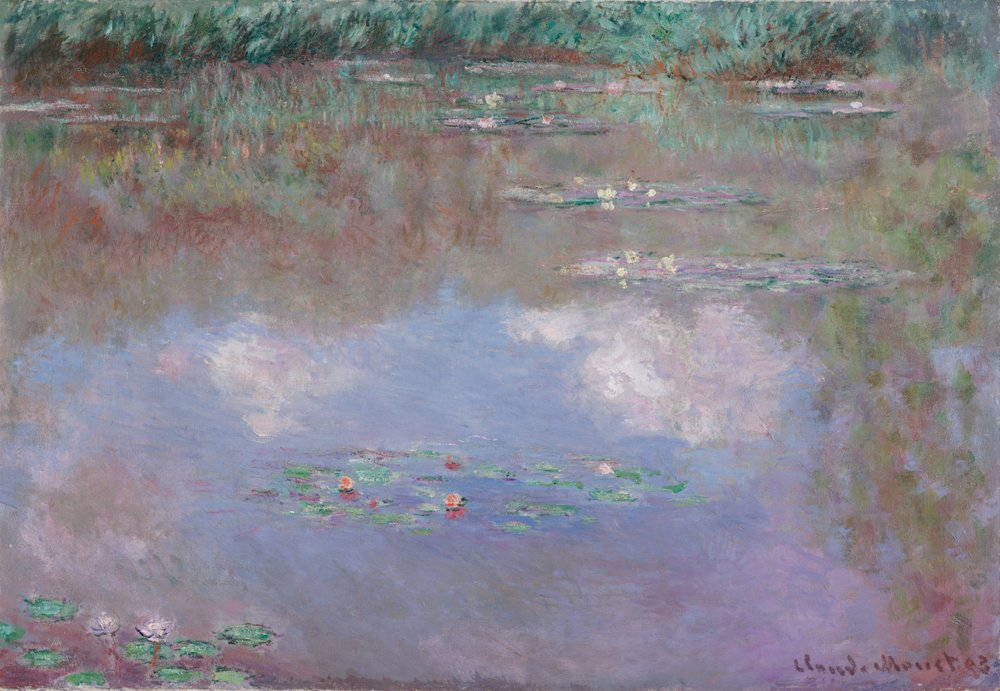

In [68]:
img_impres

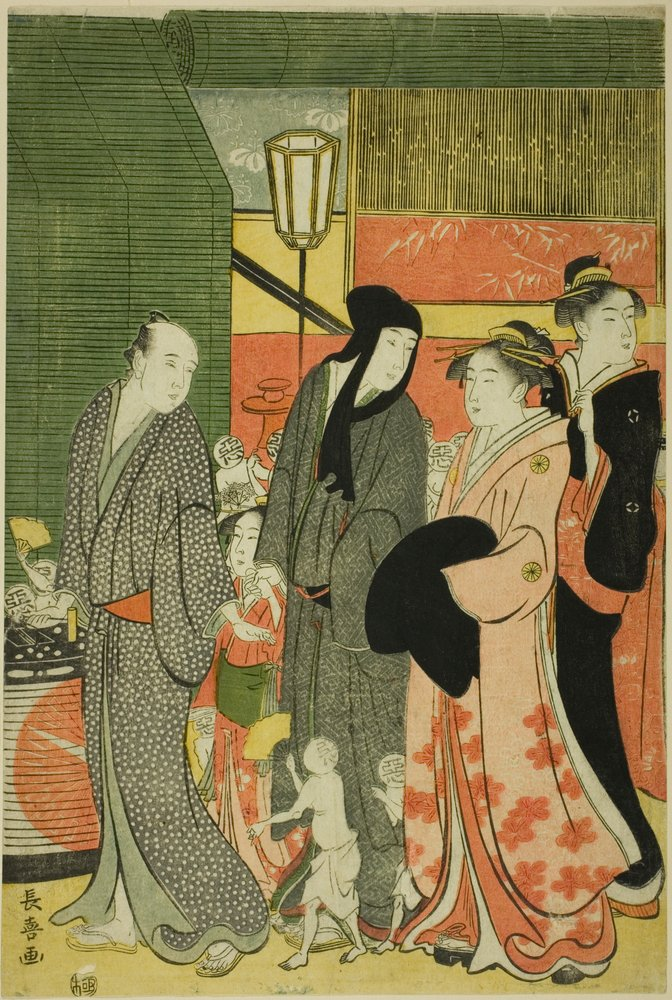

In [69]:
img_ukiyoe

In [58]:
img_impres_process = pipeline_preprocess(img_impres)
img_ukiyoe_process = pipeline_preprocess(img_ukiyoe)

In [70]:
model.eval()
image1 = None # impressionism
image2 = None # ukiyo-e

with torch.no_grad():
  input = img_impres_process.unsqueeze(0).to(device) # processa e adiciona a dimensão do batch
  output = model(input)
  _, preds = torch.max(output, 1)
  image1 = preds

  input = img_ukiyoe_process.unsqueeze(0).to(device)
  output = model(input)
  _, preds = torch.max(output, 1)
  image2 = preds

In [71]:
# Impressionism - 4
# Ukiyo_e - 12

image1, image2

(tensor([4], device='cuda:0'), tensor([12], device='cuda:0'))